Chargement des librairies

In [195]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import convolve2d
import ot
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

Paramétrisation des affichages graphiques et création d'une fonction `affichage_matrices` qui permet de visualiser les cartes de dose simulées.

In [196]:
top = cm.get_cmap('viridis', 64)

bottom = cm.get_cmap('plasma', 960)

newcolors = np.vstack((top(np.linspace(0, 1, 64)),

                       bottom(np.linspace(1, 0, 960))))

newcmp = ListedColormap(newcolors, name='MonteCarlo')

/tmp/ipykernel_49220/2658366827.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_49220/2658366827.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('plasma', 960)


In [197]:
def affichage_matrices(matrice_reference, matrice_bruitee, matrice_metrique, metrique_name):
    #plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Matrice de référence")
    plt.imshow(matrice_reference, cmap=newcmp)
    #plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Matrice bruitée")
    plt.imshow(matrice_bruitee, cmap=newcmp)
    #plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title(f"Métrique : {metrique_name}")
    plt.imshow(matrice_metrique, cmap=newcmp)
    #plt.colorbar()

    plt.tight_layout()
    plt.show()

La fonction `create_data` permet de simuler des cartes de doses de taille 64x64. L'une des deux cartes de dose simulées possède un bruit fixe dans la bande verticale centrale. 

In [198]:
# 2ème version de la génération des matrices pour ajouter du bruit (écart-type tiré aléatoirement pour chaque point)

def create_data(size_carte, niveauBiais) :

 
   #Matrice des variances et moyennes : modèle
   mat_variance = np.abs(np.random.normal(0, 1, size=(size_carte, size_carte)))
   mat_moyenne = np.abs(np.random.normal(0, 1, size=(size_carte, size_carte)))

   #Matrice des nombres d'échantillons
   mat_nombres_ech1 = np.random.randint(100, 120, (size_carte,size_carte)) 
   mat_nombres_ech2 = mat_nombres_ech1 + np.random.randint(-10, 10, (size_carte, size_carte))


   taille=mat_nombres_ech1[9:55,9:55].shape
   mat_nombres_ech1[9:55,9:55] = np.random.randint(1000, 1200, (taille)) 
   mat_nombres_ech2[9:55,9:55] = mat_nombres_ech1[9:55,9:55] + np.random.randint(-50, 50, (taille)) 

   taille=mat_nombres_ech1[18:46,18:46].shape
   mat_nombres_ech1[18:46,18:46] = np.random.randint(5000, 5500, (taille)) 
   mat_nombres_ech2[18:46,18:46] = mat_nombres_ech1[18:46,18:46] + np.random.randint(-200, 200, (taille)) 

   taille=mat_nombres_ech1[27:37,27:37].shape
   mat_nombres_ech1[27:37,27:37] = np.random.randint(10000, 11000, (taille)) 
   mat_nombres_ech2[27:37,27:37] = mat_nombres_ech1[27:37,27:37] + np.random.randint(-1000, 1000, (taille)) 


   # Générer les cartes 

   stock1={}
   stock2={}
   carte1 = np.zeros((size_carte,size_carte))
   carte2 = np.zeros((size_carte,size_carte))
   var_carte1= np.zeros((size_carte,size_carte))
   var_carte2= np.zeros((size_carte,size_carte))


   for l in range(size_carte):
      for c in range(size_carte):
         stock1[str(l)+str(c)] = np.abs(np.random.normal(mat_variance[l,c], mat_moyenne[l,c], mat_nombres_ech1[l,c]))
         stock2[str(l)+str(c)] = np.abs(np.random.normal(mat_variance[l,c], mat_moyenne[l,c], mat_nombres_ech2[l,c]))
         
         #bruit = np.random.normal(0, 0.005, mat_nombres_ech2[l,c])
         #stock2[str(l)+str(c)] = stock2[str(l)+str(c)]#+ bruit
         
         stock1[str(l)+str(c)] = stock1[str(l)+str(c)]/(stock1[str(l)+str(c)].max())
         stock2[str(l)+str(c)] = stock2[str(l)+str(c)]/(stock2[str(l)+str(c)].max())


         carte1[l,c] = np.mean(stock1[str(l)+str(c)])
         var_carte1[l,c] = np.std(stock1[str(l)+str(c)])

         carte2[l,c] = np.mean(stock2[str(l)+str(c)])
         var_carte2[l,c] = np.std(stock2[str(l)+str(c)])

   #Ajoute biais

   for l in range(size_carte):
      for c in range(30,35):
         stock2[str(l)+str(c)] = stock2[str(l)+str(c)] + niveauBiais
         stock2[str(l)+str(c)] = stock2[str(l)+str(c)]/(stock2[str(l)+str(c)].max())
         carte2[l,c] = np.mean(stock2[str(l)+str(c)])
         var_carte2[l,c] = np.std(stock2[str(l)+str(c)])


   
   return carte1, carte2, mat_nombres_ech1, mat_nombres_ech2, var_carte1, var_carte2, stock1, stock2

On définit les métriques classiques qui permettent d'évaluer la différence entre deux cartes de dose (représentées ici par des matrices) :

In [199]:
def mse(A, B):
    return (A - B) ** 2


def mae(A, B):
    return np.abs(A - B)


def t_test(matrice_ref, matrice_bruit, matrice_taille_ech_ref, matrice_taille_ech_bruit, matrice_ecart_type_ref, matrice_ecart_type_bruit, matrice_size = 100):
    t_test_matrix = np.zeros((matrice_size, matrice_size))

    for i in range(matrice_size):
        for j in range(matrice_size):
            mean1 = matrice_ref[i][j]
            mean2 = matrice_bruit[i][j]
            n1 = matrice_taille_ech_ref[i][j]
            n2 = matrice_taille_ech_bruit[i][j]
            sd1 = matrice_ecart_type_ref[i][j]
            sd2 = matrice_ecart_type_bruit[i][j]

            t_stat = (mean1 - mean2) / np.sqrt(sd1**2/n1 + sd2**2/n2)

            ddl = (sd1**2/n1 + sd2**2/n2)**2 / ((sd1**2/n1)**2/(n1-1) + (sd2**2/n2)**2/(n2-1))

            p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=ddl))
    
            if (p_value < 0.05):
                t_test_matrix[i][j] = 1
            else:
                t_test_matrix[i][j] = 0

    return t_test_matrix



def ssim(img1, img2, K1=0.01, K2=0.03, L=1, window_size=7, sigma=1):
    """
    Calcule le SSIM (Structural Similarity Index) entre deux images img1 et img2.

    Parameters :
        img1, img2 : images (matrices numpy)
        K1, K2     : constantes de stabilisation
        L          : plage dynamique des valeurs (ici on normalise donc L=1)
        window_size : taille du noyau gaussien utilisé pour lisser (fenêtre)
        sigma      : écart-type du noyau gaussien

    Return :
        SSIM moyen entre les deux images (float)
    """

    def normalize(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    img1 = normalize(img1)
    img2 = normalize(img2)

    # Construction d'un noyau gaussien pour le lissage local
    half = window_size // 2
    coords = np.arange(-half, half+1)
    # Noyau gaussien : window[i, j] = exp(-(i² + j²) / (2 sigma²))
    window = np.exp(-(coords[:, None]**2 + coords[None, :]**2) / (2 * sigma**2))
    window /= np.sum(window)

    # Convolution avec gestion des bords
    # "same" : même taille que l’image
    # "symm" : symétrie des bords
    conv = lambda X: convolve2d(X, window, mode='same', boundary='symm')

    # Moyennes locales
    mu1 = conv(img1)
    mu2 = conv(img2)

    # Variances et covariance locales
    sigma1_sq = conv(img1**2) - mu1**2
    sigma2_sq = conv(img2**2) - mu2**2
    sigma12   = conv(img1 * img2) - mu1 * mu2

    # Termes de stabilisation (évite les divisions par zéro)
    C1 = (K1*L)**2
    C2 = (K2*L)**2

    # Formule du SSIM pixel par pixel
    ssim_map = ((2*mu1*mu2 + C1) * (2*sigma12 + C2)) / \
               ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))

    # Retourne le SSIM moyen sans les valeurs NaN aux bords
    return ssim_map



def gamma_index(A, B, dose_diff_crit=0.03, dist_crit=3, pixel=1):
    """
    Calcule l'indice gamma entre deux matrices A et B qui représentent des cartes de dose.

    Parameters :
    -----------
    A, B : matrices numpy
    dose_diff_crit : float
        Critère de différence de dose 
    dist_crit : float
        Critère de glissement spatial entre les pixels (mm)
    pixel : float
        Taille d’un pixel (mm), utilisé pour convertir en distance réelle

    Return :
    --------
    gamma_map : matrice contenant, pour chaque pixel (i,j),
                la valeur minimale du gamma par rapport à tous les autres.
    """

    # Dimensions des matrices
    nr, nc = A.shape

    # Meshgrid permet de vectoriser les calculs de distance
    x = np.arange(nr)
    y = np.arange(nc)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Carte gamma initialisée à zéro (remplie pixel par pixel)
    gamma_map = np.zeros((nr, nc))

    for i in range(nr):
        for j in range(nc):
            # Calcul des distances et différences de dose entre le pixel (i,j) de la matrice A
            # et tous les pixels de la matrice B
            dist = np.sqrt((pixel * (X - i))**2 + (pixel * (Y - j))**2)
            dose_diff = np.abs(A[i, j] - B)

            # Calcul de la matrice gamma pour le pixel (i,j)
            gamma_matrix = np.sqrt(
                (dose_diff / dose_diff_crit)**2 +
                (dist / dist_crit)**2
            )

            # Valeur minimale du gamma pour le pixel (i,j)
            gamma_map[i, j] = np.min(gamma_matrix)

    return gamma_map

Nous implantons maintenant plusieurs fonctions qui permettent de calculer la distance de Wasserstein entre deux matrices (fonction finale `wasserstein`). 

In [200]:
def create_fdr_optimized(cdf, ech, t):
    """
    Crée la fonction de répartition inverse
    """
    # Trouver les indices correspondants dans t pour chaque valeur de cdf
    cdf_index = np.searchsorted(t, cdf, side='left')
    
    F = np.zeros(len(t), dtype=ech.dtype)
    
    start_idx = 0
    for i, idx in enumerate(cdf_index):
        F[start_idx:idx+1] = ech[i]
        start_idx = idx + 1
    
    return F


def calculate_k_optimized(t):
    # Calcule les différences entre éléments consécutifs
    k = np.diff(t, prepend=0)
    return k


def wasserstein_one_pixel(ech1, ech2):

    ech1 = ech1 / np.sum(ech1)
    ech2 = ech2 / np.sum(ech2)

    ech1 = np.asarray(ech1, dtype=np.float32).ravel()
    ech2 = np.asarray(ech2, dtype=np.float32).ravel()
    
    # Trier les distributions
    ech1_trie = np.sort(ech1)
    ech2_trie = np.sort(ech2)
    
    n1, n2 = len(ech1_trie), len(ech2_trie)
    
    # Créer les CDF empiriques (version optimisée)
    cdf_1 = np.arange(1, n1 + 1, dtype=np.float32) / n1
    cdf_2 = np.arange(1, n2 + 1, dtype=np.float32) / n2
    
    # Combiner et obtenir valeurs uniques
    t = np.unique(np.concatenate([cdf_1, cdf_2]))
    
    # Créer les fonctions de répartition inverses
    ech1_q = create_fdr_optimized(cdf_1, ech1_trie, t)
    ech2_q = create_fdr_optimized(cdf_2, ech2_trie, t)
    
    # Calculer k
    k = calculate_k_optimized(t)

    
    # Distance de Wasserstein
    wasserstein_empirique = np.sum(np.abs(ech1_q - ech2_q) * k)

    
    return wasserstein_empirique


def wasserstein(matrices_simulees_ref, matrices_simulees_bruitees, 
                                     matrice_size=100):

    wasserstein_map = np.zeros((matrice_size, matrice_size))
      
    for i in tqdm(range(matrice_size), desc="Calcul Wasserstein"):
        for j in range(matrice_size):
            if isinstance(matrices_simulees_ref, dict):
                key = str(i) + str(j)
                wasserstein_map[i, j] = wasserstein_one_pixel(
                    matrices_simulees_ref[key],
                    matrices_simulees_bruitees[key]
                )
            else:
                wasserstein_map[i, j] = wasserstein_one_pixel(
                    matrices_simulees_ref[i][j],
                    matrices_simulees_bruitees[i][j]
                )
    
    return wasserstein_map

Nous implantons ensuite trois fonctions qui permettent de calculer les 100 premiers moments pour chaque pixel des cartes de doses simulées, puis qui appliquent la distance de wasserstein sur ces moments. 

In [201]:

def calcul_100_moments(ech):
    ech = np.asarray(ech, dtype=np.float64)
    
    moments = np.zeros(101, dtype=np.float64)
    power = np.ones_like(ech)  # commence à puissance 0 (ech^0 = 1)
    
    for i in range(101):
        moments[i] = np.mean(power)
        power *= ech  # puissance suivante
    
    return list(moments[1:])


def create_matrice_moments(matrices_simulees, matrice_size=100):
    matrice_moments = [[[] for _ in range(matrice_size)] for _ in range(matrice_size)]   

    for i in tqdm(range(matrice_size)):
        for j in range(matrice_size):
            if isinstance(matrices_simulees, dict):
                key = str(i) + str(j)
                ech = matrices_simulees[key]
                moments_100 = calcul_100_moments(ech)
                matrice_moments[i][j] = moments_100
            else:
                ech = matrices_simulees[i][j]
                moments_100 = calcul_100_moments(ech)
                matrice_moments[i][j] = moments_100
                
    return matrice_moments


def apply_wasserstein_to_moments(matrices_simulees_ref, matrices_simulees_bruit, matrice_size=100):
    matrice_moments_ref = create_matrice_moments(matrices_simulees_ref, matrice_size)
    matrice_moments_bruit = create_matrice_moments(matrices_simulees_bruit, matrice_size)

    for i in range(matrice_size):
        for j in range(matrice_size):
            matrice_moments_bruit[i][j] = matrice_moments_bruit[i][j] / np.sum(matrice_moments_bruit[i][j])  # Normalisation pour que la somme soit 1
            matrice_moments_ref[i][j] = matrice_moments_ref[i][j] / np.sum(matrice_moments_ref[i][j])  # Normalisation pour que la somme soit 1

    print(matrice_moments_ref[0][0])  # Affiche les 10 premiers moments du pixel (0,0) de la matrice de référence

    wasserstein_moments_map = wasserstein(matrice_moments_ref, matrice_moments_bruit, matrice_size)

    return wasserstein_moments_map

Maintenant que toutes les fonctions de métriques sont implantées, nous simulons deux matrices (une matrice bruitée et une matrice de référence non bruitée) puis nous calculons la différence entre ces deux matrices selon les différentes métriques. Le bruit de la matrice bruitée vaut 0,05.

In [202]:
carte1, carte2, mat_nombres_ech1, mat_nombres_ech2, std_carte1, std_carte2, stock1, stock2 = create_data(64, 0.05)

In [203]:
MSE_bis = mse(carte1, carte2)
MAE_bis = mae(carte1, carte2)
SSIM_bis = ssim(carte1, carte2)
GAMMA_INDEX_bis = gamma_index(carte1, carte2)
WASSERSTEIN_bis = wasserstein(stock1, stock2, 64)
TTEST_bis = t_test(carte1, carte2, mat_nombres_ech1, mat_nombres_ech2, std_carte1, std_carte2, 64)
WASSERSTEIN_MOMENTS_bis = apply_wasserstein_to_moments(stock1, stock2, 64)

100%|██████████| 64/64 [00:01<00:00, 36.05it/s]


[0.19208726 0.09044495 0.05193395 0.03394161 0.02431564 0.01865473
 0.0150904  0.01272916 0.01110215 0.00994484 0.0090993  0.00846707
 0.00798457 0.00760955 0.00731327 0.00707573 0.00688276 0.00672415
 0.00659239 0.00648192 0.00638853 0.006309   0.00624084 0.00618209
 0.00613121 0.00608694 0.00604829 0.00601444 0.0059847  0.0059585
 0.00593539 0.00591495 0.00589686 0.00588081 0.00586656 0.0058539
 0.00584264 0.00583262 0.00582369 0.00581574 0.00580864 0.00580232
 0.00579667 0.00579163 0.00578713 0.00578311 0.00577953 0.00577632
 0.00577346 0.0057709  0.00576861 0.00576656 0.00576474 0.0057631
 0.00576164 0.00576034 0.00575917 0.00575813 0.00575719 0.00575636
 0.00575561 0.00575495 0.00575435 0.00575382 0.00575334 0.00575292
 0.00575253 0.00575219 0.00575189 0.00575162 0.00575137 0.00575115
 0.00575096 0.00575078 0.00575063 0.00575049 0.00575036 0.00575025
 0.00575015 0.00575006 0.00574998 0.00574991 0.00574985 0.00574979
 0.00574974 0.0057497  0.00574965 0.00574962 0.00574959 0.0057495

Calcul Wasserstein: 100%|██████████| 64/64 [00:00<00:00, 89.82it/s] 


Affichage des deux cartes de dose simulées ainsi que la métrique associé.

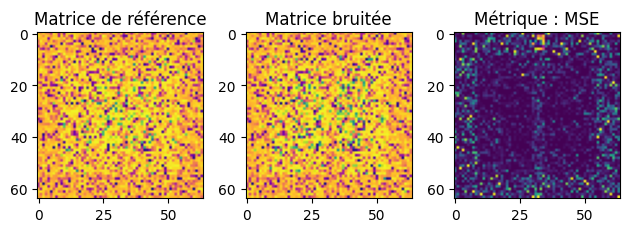

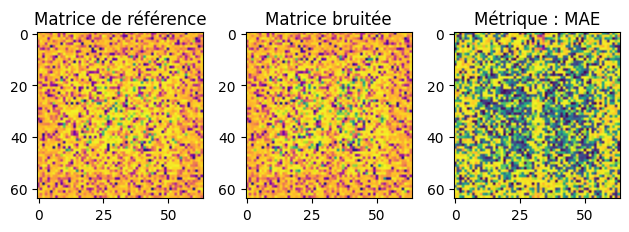

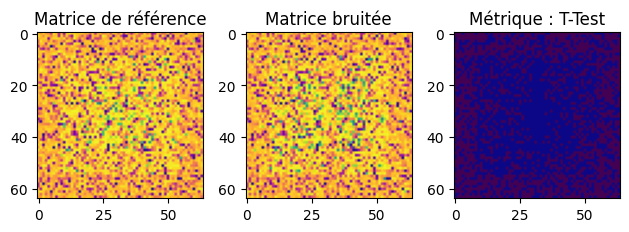

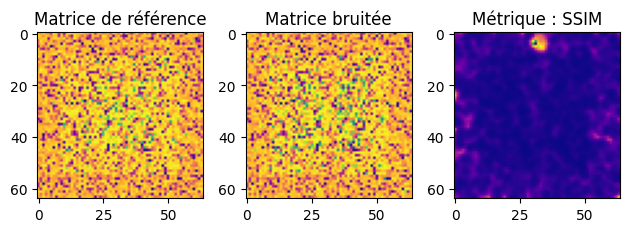

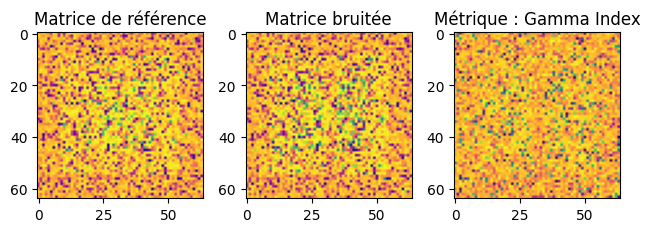

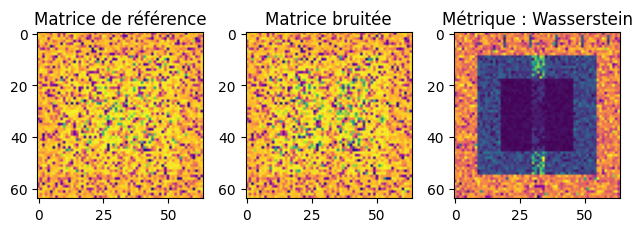

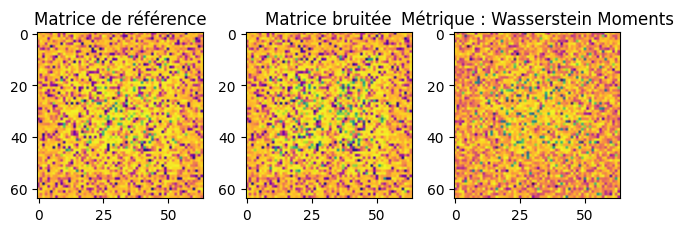

In [204]:
affichage_matrices(carte1, carte2, MSE_bis, "MSE")
affichage_matrices(carte1, carte2, MAE_bis, "MAE")
affichage_matrices(carte1, carte2, TTEST_bis, "T-Test")
affichage_matrices(carte1, carte2, SSIM_bis, "SSIM")
affichage_matrices(carte1, carte2, GAMMA_INDEX_bis, "Gamma Index")
affichage_matrices(carte1, carte2, WASSERSTEIN_bis, "Wasserstein")
affichage_matrices(carte1, carte2, WASSERSTEIN_MOMENTS_bis, "Wasserstein Moments")

Nous parvenons à discerner la zone bruitée pour le MSE, le MAE et la distance de Wasserstein. Pour cette dernière, la zone bruitée apparaît plus nettement au centre (échantillons de plus grande taille). 

Pour l'approximation de Wassertstein à l'aide des 100 premiers moments, on discerne la zone bruitée au centre (zone où les échantillons sont les plus grands).

En ce qui concerne les autres métriques, la zone bruitée apparaît moins nettement voire pas du tout.

L'objectif suivant est d'effectuer une combinaison linéaire de moments pour tenter d'approximer la distance de Wasserstein.

Or, nous avons à notre disposition les moments relatifs à chaque pixel pour les deux matrices (bruitée et non bruitée). Nous ne voyons pas comment faire pour regrouper ces moments de plusieurs matrices en une seule combinaison linéaire que l'on pourrait plot. 

In [205]:
matrice_moments_ref = create_matrice_moments(stock1, 64)
matrice_moments_bruit = create_matrice_moments(stock2, 64)

100%|██████████| 64/64 [00:02<00:00, 25.11it/s]


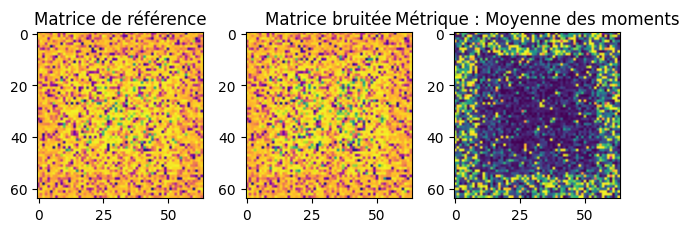

In [207]:
def moyenne_moments(matrice_moments):
    for i in range(len(matrice_moments)):
        for j in range(len(matrice_moments[i])):
            matrice_moments[i][j] = np.mean(matrice_moments[i][j])
    return matrice_moments

matrice_moments_ref_moyenne = moyenne_moments(matrice_moments_ref)
matrice_moments_bruit_moyenne = moyenne_moments(matrice_moments_bruit)

affichage_matrices(carte1, carte2, mae(np.array(matrice_moments_ref_moyenne), np.array(matrice_moments_bruit_moyenne)), "Moyenne des moments")